# Imports & Setups

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import itertools
from math import ceil

from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC

from sklearn.metrics import confusion_matrix,f1_score,roc_auc_score

import warnings 

import lib.kotools as kt

In [2]:
%load_ext autoreload
%autoreload 2
sns.set()
warnings.simplefilter('ignore')
pd.set_option('display.max_columns', 7)

# Load data

Data source is https://archive.ics.uci.edu/ml/datasets/SECOM

In [3]:
df_raw = pd.read_csv('./input/secom.data',sep=' ',header=None)
labels = pd.read_csv('./input/secom_labels.data',sep=' ',header=None,usecols=[0],squeeze = True)
df_raw['TARGET'] = labels
df_raw.shape

(1567, 591)

In [4]:
kt.df_feats_summary(df_= df_raw, cols_to_exclude=['TARGET']);

Columns summary (total 591) : 
        1. Categorical: 0
        2. Numerical: 590
        3. Excluded: 1


In [5]:
df_raw.head()

,0,1,2,...,588,589,TARGET
0,3030.93,2564.00,2187.7333,...,NaN,NaN,-1
1,3095.78,2465.14,2230.4222,...,0.0060,208.2045,-1
2,2932.61,2559.94,2186.4111,...,0.0148,82.8602,1
3,2988.72,2479.90,2199.0333,...,0.0044,73.8432,-1
4,3032.24,2502.87,2233.3667,...,0.0044,73.8432,-1


In [6]:
df_raw['TARGET'].value_counts()

-1    1463
 1     104
Name: TARGET, dtype: int64

# Dataframe Transformation

In [7]:
df = df_raw.copy()
df = kt.df_reduce_mem_usage(df);

Memory usage of dataframe: 7.07 MB
Memory usage after optimization: 2.82 MB
Decreased by 60.0%


# Train / test split

In [8]:
X = df.copy()
y = df['TARGET'].copy()
X.drop(['TARGET'],axis=1,inplace=True) # Exclude target variable from X dataframe

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=42)
print('X_train shape:{} \nX_test shape:{}'.format(X_train.shape,X_test.shape))

X_train shape:(1253, 590) 
X_test shape:(314, 590)


# Exploratory data analysis

## Missing Values

### Missing Values Exploring

For X_train:

In [9]:
kt.df_missing_report(X_train).sort_values(by='ratio_missing',ascending=False).head(10)

,count_missing,ratio_missing
157,1138,0.908220
293,1138,0.908220
292,1138,0.908220
158,1138,0.908220
85,1070,0.853951
220,1070,0.853951
492,1070,0.853951
358,1070,0.853951
383,816,0.651237
110,816,0.651237


For X_test:

In [10]:
kt.df_missing_report(X_test).sort_values(by='ratio_missing',ascending=False).head(10)

,count_missing,ratio_missing
158,291,0.926752
157,291,0.926752
293,291,0.926752
292,291,0.926752
492,271,0.863057
85,271,0.863057
358,271,0.863057
220,271,0.863057
516,202,0.643312
245,202,0.643312


### Missing Values Columns Drop

In [11]:
cutoff = 0.80
nan_cols_to_drop = X_train.columns[(((X_train.isnull().sum()/X_train.shape[0])>cutoff) | \
                                    ((X_test.isnull().sum()/X_test.shape[0])>cutoff))]

print('Count of columns to drop:',len(nan_cols_to_drop)) 

X_train.drop(nan_cols_to_drop,axis=1,inplace=True)
X_test.drop(nan_cols_to_drop,axis=1,inplace=True)

print('actual X_train shape:{} \nactual X_test shape:{}'.format(X_train.shape,X_test.shape))

Count of columns to drop: 8
actual X_train shape:(1253, 582) 
actual X_test shape:(314, 582)


### Missing Values Imputation

In [12]:
nan_cols = X_train.columns[X_train.isna().any()]
if len(nan_cols)>0:
    X_train[nan_cols] = kt.df_impute(X_train[nan_cols],strategy='median')

nan_cols = list(X_test.columns[X_test.isna().any()])
if len(nan_cols)>0:
    X_test[nan_cols] = kt.df_impute(X_test[nan_cols],strategy='median')

## Constant Values

### Constant Values Exploring 

In [13]:
const_cols = X_train.columns[(((X_train == X_train.iloc[0]).all())|\
                              (X_test == X_test.iloc[0]).all())]
print('Count of columns with constant value:',len(const_cols))

Count of columns with constant value: 122


### Constant Values Columns Drop

In [14]:
X_train.drop(const_cols,axis=1,inplace=True)
X_test.drop(const_cols,axis=1,inplace=True)

print('X_train shape:{} \nX_test shape:{}'.format(X_train.shape,X_test.shape))

X_train shape:(1253, 460) 
X_test shape:(314, 460)


## Correlation

In [15]:
# Find correlations with the target and sort
correlations = X_train.corrwith(y_train).sort_values(ascending = False)

# Display correlations
print('Most Positive Correlations:\n', correlations.head(5))
print('\nMost Negative Correlations:\n', correlations.tail(5))

Most Positive Correlations:
 103    0.166613
59     0.164126
510    0.147652
431    0.140725
434    0.128902
dtype: float64

Most Negative Correlations:
 122   -0.089176
26    -0.099154
28    -0.100750
316   -0.102978
125   -0.103152
dtype: float64


# Data Transformation

## Normalization

In [16]:
_, cat_cols,num_cols = kt.df_feats_summary(X_train,[],verbose=False)
X_train[num_cols] = kt.df_scale(X_train[num_cols],strategy='minmax')
X_test[num_cols] = kt.df_scale(X_test[num_cols],strategy='minmax')

# Selection the best classic model

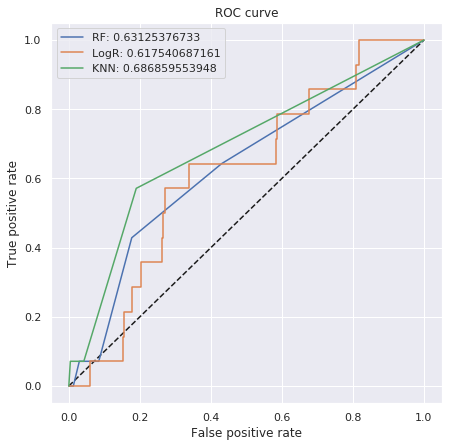

In [17]:
feature_importance = kt.plot_roc_curves(X_train, y_train, random_state = 0)